## Predicting Dota 2 Match Outcomes

In this notebook, we will look at public matchmaking data for the video game Dota 2. I will be trying to predict the outcome of a match from information only available before it begins.

I will keep to two categories of information: the heroes drafted and the location of the server the match was 
played on.

## Loading Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# statistical tests
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as stats


# learning libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

# model evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# mount Google Drive to load files

from google.colab import drive
from pathlib import Path
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
path = '/content/gdrive/MyDrive/Thinkful - DS Flex/DOTA Data/Capstone II/'

# load relevant tables for our model
matches = pd.read_csv(path + 'matches.csv')
players = pd.read_csv(path + 'players.csv')
heroes = pd.read_csv(path + 'heroes.csv')
regions = pd.read_csv(path + 'regions.csv')

heroes.rename(columns={"id": 'hero_id'}, inplace = True)


## Data Analysis and Feature Engineering

Our goal will be to make predictions on the outcome of a game based on the hero composition of each team and what matchmaking server the game occured on.

I pulled the data from the datdota.com API on April 23-24 2022.

Radiant Win rate: 0.497641282372196
Dire Win rate: 0.5023587176278039


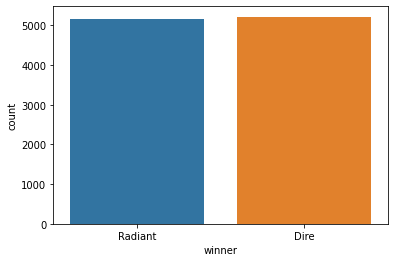

In [4]:
matches['winner'] = ['Radiant' if radiant_win else 'Dire' for radiant_win in matches['radiant_win']]

print('Radiant Win rate: {}'.format(matches['radiant_win'].mean()))
print('Dire Win rate: {}'.format(1 - matches['radiant_win'].mean()))
sns.countplot(x = 'winner', data = matches)
plt.show()

We have a very balanced dataset in terms of winning side. Let's see if there's differences in the Radiant win rate to be gleaned from the regions of play.

In [5]:
# merge the matches table with the regions to get readable region names
matches = matches.merge(regions, how = 'left', on = 'region')

matches.groupby('region_name')['radiant_win'].mean().sort_values(ascending = False)

region_name
PW UNICOM TIANJIN       0.588235
PW TELECOM GUANGDONG    0.584158
PW TELECOM ZHEJIANG     0.567797
JAPAN                   0.547059
US WEST                 0.544910
PW UNICOM               0.534483
BRAZIL                  0.517500
STOCKHOLM               0.515496
SINGAPORE               0.495517
ARGENTINA               0.487500
US EAST                 0.484746
EUROPE                  0.475997
CHILE                   0.473469
AUSTRIA                 0.470721
PW TELECOM WUHAN        0.469979
PERU                    0.468174
AUSTRALIA               0.372093
Name: radiant_win, dtype: float64

It looks like Radiant is the favord side of 3 out of 4 Chinsese regions while Dire is largely favored Australia. We must investigate further to see if the sample sizes from each region are enough to show that these are significant differences.

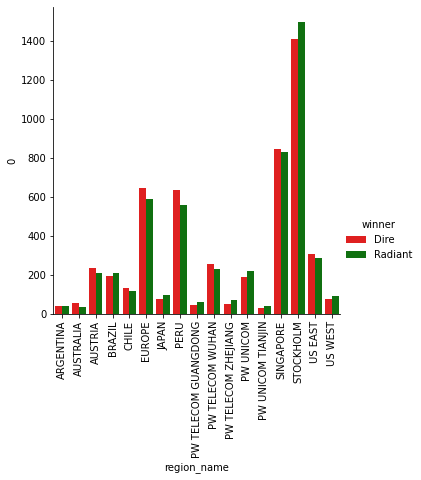

In [6]:
regional_win_counts = matches.groupby(['region_name', 'winner']).size().reset_index()

sns.catplot(data = regional_win_counts, x = 'region_name', hue = 'winner', y = 0, kind = 'bar', palette = sns.color_palette(['red', 'green']))
plt.xticks(rotation=90)
plt.style.context('dark_background')
plt.show()

The number of games from each reagion vary wildly from Stokholm at almost three thousand to Argentina or Australia at about 100 games.



In order to get a better idea if the region is relevent, let's perform a chi-squared test for independance to see if outcome of games is independent of the region where they are played.

In [7]:
crosstab = pd.crosstab(matches['winner'], matches['region_name'])
chi2, p, dof, ex = stats.chi2_contingency(crosstab)

print('Chi-Squared Test Statistic: {}'.format(chi2))
print('P-value: {}'.format(p))
print('Degrees of Freedom: {}'.format(dof))
print('Expected Values:')
print(ex)

Chi-Squared Test Statistic: 32.93675171882289
P-value: 0.007534095999395616
Degrees of Freedom: 16
Expected Values:
[[  40.20081097   43.21587179  223.11450087  201.00405484  123.11498359
   617.58495849   85.42672331  599.99710369   50.75352385  242.71239622
    59.29619618  204.01911566   34.17068932  840.69945936 1459.28943812
   296.48098088   83.91919289]
 [  39.79918903   42.78412821  220.88549913  198.99594516  121.88501641
   611.41504151   84.57327669  594.00289631   50.24647615  240.28760378
    58.70380382  201.98088434   33.82931068  832.30054064 1444.71056188
   293.51901912   83.08080711]]


We can see that all expected values are greater than 5. Observations in are dataset are also assumed to be independent of one another.

With a p-value < 0.05, there is that the team (Radiant or Dire) that is expected to win a game is affected by the region where the game is played making this information good for inclusion into our model.

I would also like to take into account the composition of each team after heroes have been drafted. We'll first look at the most commonly chosen heroes and assess the practicality of using this information.

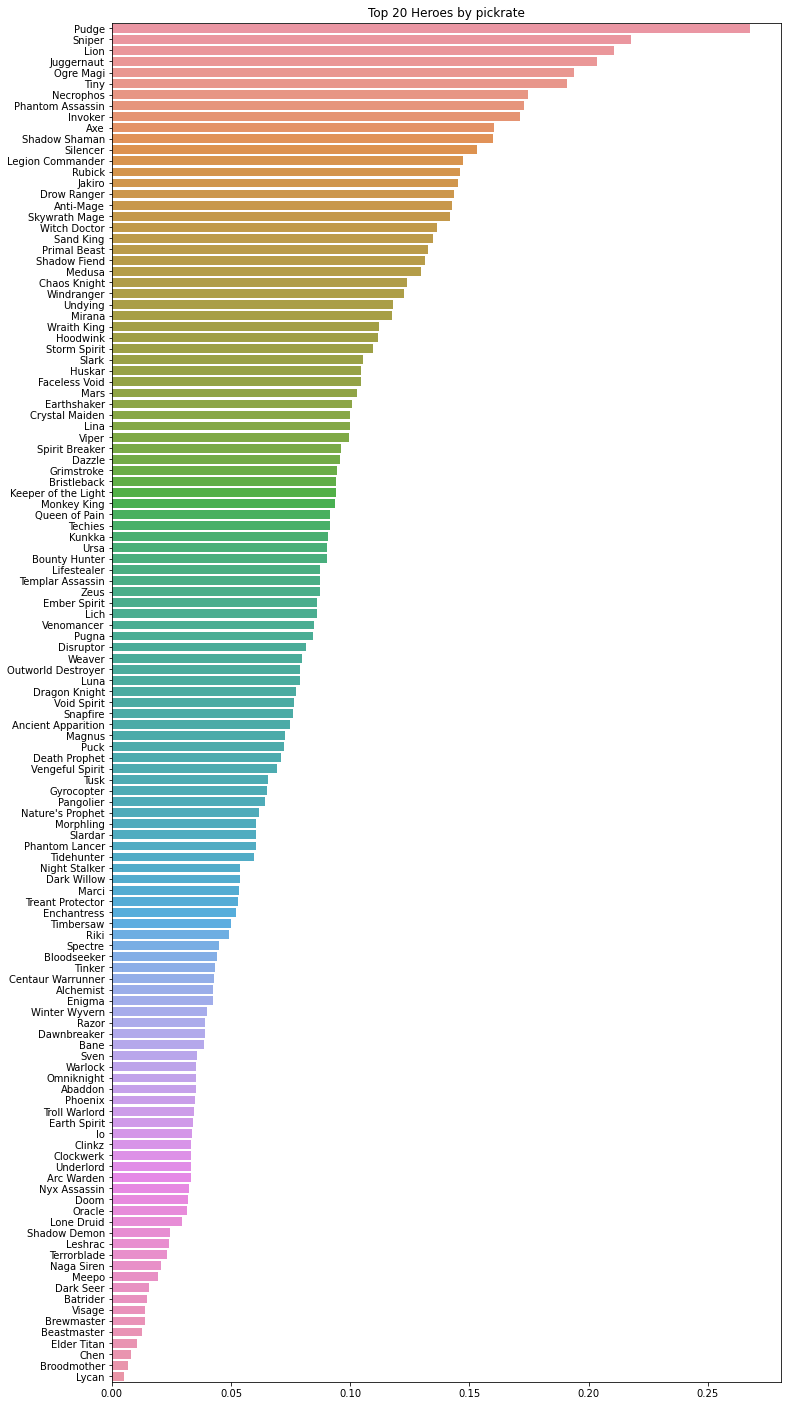

In [8]:
# Merge our player information with hero data to get readable hero names and get the frequency of each hero
players_with_heroes = pd.merge(players, heroes[['localized_name', 'hero_id']], how = 'left', on = 'hero_id')
data = players_with_heroes['localized_name'].value_counts()

fig, ax = plt.subplots(figsize=(12, 25))
sns.barplot(x = data.values/len(matches), y = data.index)
plt.style.context('dark_background')
plt.title('Top 20 Heroes by pickrate')
plt.show()


Woa.

Even the most popular hero, Pudge, only appears in about 26% of games while most appear in less that 12%. With over 110 heroes and 5 heroes chosen per team, it will be better to find a way to summarize each team's composition instead.

Each hero has a list of roles that it's tagged with. The tags are human-generated and meant to indicate what parts of the game the hero will be good at.

In [9]:
roles = ['Carry', 'Support', 'Nuker', 'Disabler', 'Jungler', 'Durable', 'Escape', 'Pusher', 'Initiator']

# add columns to the heroes indicating, with 0 or 1, what roles it's tagged with
for role in roles:
  heroes[role] = [1 if role in hero_roles else 0 for hero_roles in heroes['roles']]

heroes.head()

,Unnamed: 0,hero_id,name,localized_name,primary_attr,attack_type,roles,legs,Carry,Support,Nuker,Disabler,Jungler,Durable,Escape,Pusher,Initiator
0,0,1,npc_dota_hero_antimage,Anti-Mage,agi,Melee,"['Carry', 'Escape', 'Nuker']",2,1,0,1,0,0,0,1,0,0
1,1,2,npc_dota_hero_axe,Axe,str,Melee,"['Initiator', 'Durable', 'Disabler', 'Jungler'...",2,1,0,0,1,1,1,0,0,1
2,2,3,npc_dota_hero_bane,Bane,int,Ranged,"['Support', 'Disabler', 'Nuker', 'Durable']",4,0,1,1,1,0,1,0,0,0
3,3,4,npc_dota_hero_bloodseeker,Bloodseeker,agi,Melee,"['Carry', 'Disabler', 'Jungler', 'Nuker', 'Ini...",2,1,0,1,1,1,0,0,0,1
4,4,5,npc_dota_hero_crystal_maiden,Crystal Maiden,int,Ranged,"['Support', 'Disabler', 'Nuker', 'Jungler']",2,0,1,1,1,1,0,0,0,0


In [10]:
# Merge this new information into our players table
columns = roles + ['localized_name', 'hero_id']
players_with_heroes = pd.merge(players, heroes[columns], how = 'left', on = 'hero_id')

players_with_heroes.head()

,Unnamed: 0,Unnamed: 0.1,match_id,player_slot,account_id,hero_id,kills,deaths,assists,last_hits,...,Carry,Support,Nuker,Disabler,Jungler,Durable,Escape,Pusher,Initiator,localized_name
0,0,0,6539864010,0,9.214688e+08,59,4,0,5,106,...,1,0,0,0,0,1,0,0,1,Huskar
1,1,1,6539864010,1,8.103391e+06,37,4,0,3,30,...,0,1,0,1,0,0,0,0,1,Warlock
2,2,2,6539864010,2,1.051602e+09,1,1,0,1,168,...,1,0,1,0,0,0,1,0,0,Anti-Mage
3,3,3,6539864010,3,2.363199e+08,79,1,5,3,15,...,0,1,1,1,0,0,0,0,1,Shadow Demon
4,4,4,6539864010,4,NaN,47,3,0,5,117,...,1,0,0,1,0,1,0,0,1,Viper


In [11]:
# Group this information by match and team
players_with_heroes['Radiant'] = [slot < 5 for slot in players_with_heroes['player_slot']]
teams = players_with_heroes.groupby(by = ['match_id', 'Radiant']).sum()

#only keep roles, win and match ID columns, drop the rest
columns_to_drop = []
for column in teams.columns:
  if column not in roles + ['win', 'match_id']:
    columns_to_drop.append(column)
teams.drop(columns = columns_to_drop, inplace = True)

#reset win column to zeroes and ones
teams['win'] = teams['win'] / 5
teams['win'].astype('int64')

#pop out the matchid and radiant indeces as normal columns
teams.reset_index(inplace = True)
teams[teams['match_id']==6539864010]

,match_id,Radiant,win,Carry,Support,Nuker,Disabler,Jungler,Durable,Escape,Pusher,Initiator
6668,6539864010,False,0.0,3,4,3,5,0,3,0,0,4
6669,6539864010,True,1.0,3,2,2,3,0,2,1,0,4


Great! 

Each row shows a summary of the team composition for one side in every game. It has the number of heroes with each tag among the heroes that team drafted.

Now to merge this into our matches table with the region information.

In [12]:
# merge in each team's composition adding prefixes to differentiate between Radiant and Dire compositions
matches_with_teams = matches.merge(teams[teams['Radiant']], on = 'match_id')
matches_with_teams = matches_with_teams.merge(teams[ ~teams['Radiant']], on = 'match_id', suffixes = ['_radiant', '_dire'])

matches_with_teams.head()

,Unnamed: 0,Unnamed: 0.1,match_id,match_seq_num,patch,region,start_time,duration,game_mode,skill,...,win_dire,Carry_dire,Support_dire,Nuker_dire,Disabler_dire,Jungler_dire,Durable_dire,Escape_dire,Pusher_dire,Initiator_dire
0,0,0,6539864010,5462684999,50,3.0,1650821084,1113,22,NaN,...,0.0,3,4,3,5,0,3,0,0,4
1,1,1,6539862510,5462681420,50,3.0,1650821049,1052,22,NaN,...,0.0,3,3,3,4,0,2,0,0,3
2,2,2,6539860804,5462686795,50,8.0,1650820965,1397,22,NaN,...,1.0,3,3,5,4,1,0,2,2,2
3,3,3,6539860514,5462682219,50,9.0,1650820954,1149,22,NaN,...,0.0,3,4,4,4,0,1,1,0,3
4,4,4,6539860407,5462684385,50,8.0,1650820949,1283,22,NaN,...,0.0,2,3,4,3,1,0,2,1,2


Let's explore the correlation between the features we have so far and who wins a given game.

In [13]:
cols = ['radiant_win']
for role in roles:
  cols = cols + [role + '_radiant', role + '_dire']


correlations = matches_with_teams[cols].corr().unstack().reset_index()
correlations[correlations['level_0'] == 'radiant_win']


,level_0,level_1,0
0,radiant_win,radiant_win,1.000000
1,radiant_win,Carry_radiant,-0.010429
2,radiant_win,Carry_dire,0.018424
3,radiant_win,Support_radiant,0.035893
4,radiant_win,Support_dire,-0.020109
5,radiant_win,Nuker_radiant,-0.013455
6,radiant_win,Nuker_dire,0.028639
7,radiant_win,Disabler_radiant,0.011713
8,radiant_win,Disabler_dire,-0.009854
9,radiant_win,Jungler_radiant,0.015829


Our compositions information looks to be pretty weakly correlated with our target variable. It rather to be expected when limiting ourselves to only using pre game information. Lets see how much information we can gleam from these columns.

## Models

We will now explore a few different classification models. Throughout these we are only interested in the model's ability to correctly predict a winner and don't favor one side over the other. As such, we evaluate using the accuracy 

In [14]:
dataset = matches_with_teams[['radiant_win','Carry_radiant', 'Support_radiant', 'Nuker_radiant', 'Disabler_radiant','Jungler_radiant', 'Durable_radiant',
                              'Escape_radiant','Pusher_radiant', 'Initiator_radiant', 'Carry_dire', 'Support_dire', 'Nuker_dire', 'Disabler_dire','Jungler_dire',
                              'Durable_dire', 'Escape_dire', 'Pusher_dire', 'Initiator_dire', 'region_name']].copy()

# Turn our predictor column from bool to 0/1
dataset['radiant_win'] = dataset['radiant_win'].astype(int)

# Get dummy variables for our regions
dataset = pd.get_dummies(dataset, columns = ['region_name'])

dataset.head()

,radiant_win,Carry_radiant,Support_radiant,Nuker_radiant,Disabler_radiant,Jungler_radiant,Durable_radiant,Escape_radiant,Pusher_radiant,Initiator_radiant,...,region_name_PERU,region_name_PW TELECOM GUANGDONG,region_name_PW TELECOM WUHAN,region_name_PW TELECOM ZHEJIANG,region_name_PW UNICOM,region_name_PW UNICOM TIANJIN,region_name_SINGAPORE,region_name_STOCKHOLM,region_name_US EAST,region_name_US WEST
0,1,3,2,2,3,0,2,1,0,4,...,0,0,0,0,0,0,0,0,0,0
1,1,3,3,4,5,0,3,1,2,3,...,0,0,0,0,0,0,0,0,0,0
2,0,4,2,4,5,0,1,2,3,1,...,0,0,0,0,0,0,0,1,0,0
3,1,3,2,3,5,0,2,3,0,2,...,0,0,0,0,0,0,0,0,0,0
4,1,1,2,2,3,0,3,2,1,3,...,0,0,0,0,0,0,0,1,0,0


In [15]:
# Create x,y for models

X = dataset.drop(columns = ['radiant_win'])
y = dataset['radiant_win']

## Logistic Regression

In [16]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
max_iter = [100, 1000, 10000]

grid = dict(solver=solvers,penalty=penalty,C=c_values, max_iter=max_iter)

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0, verbose = 4)

results = grid_search.fit(X, y)

print('Best Score: {}'.format(results.best_score_))
print('Parameters of the best model: {}'.format(results.best_params_))

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best Score: 0.5261385642188635
Parameters of the best model: {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


Looks like we got a modest accuracy of 52.6% with logistic regression.

## Support Vector Macines

In [17]:
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)

results = grid_search.fit(X, y)

print('Best Score: {}'.format(results.best_score_))
print('Parameters of the best model: {}'.format(results.best_params_))

Best Score: 0.5266189620681714
Parameters of the best model: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}


Incredibly similar results to our logistic regression search. SVM currently gets us to 52.7% accuracy.

## Random Forest Classifier

In [18]:
model = ensemble.RandomForestClassifier()
n_estimators = [10, 100]
criterion = ['gini', 'entropy']
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators = n_estimators, criterion = criterion, max_features = max_features)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)

results = grid_search.fit(X, y)

print('Best Score: {}'.format(results.best_score_))
print('Parameters of the best model: {}'.format(results.best_params_))

Best Score: 0.5145848731442912
Parameters of the best model: {'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 100}


## Conclusion and Extenstion

None of our models were able to perform significantly better than guessing the dominant side for the data. Always predicting Dire would be correct about 50.2% of the time. Our SVM model was able to improve this to 52.7%. It's unclear how much more predictablity we can get from using just pregame data. Indeed, the game would be less interesting if the outcome was too preditable from the draft of heroes and the server location.

So where could gains be made?

Further feature engineering that directly explores the interaction between roles within and between teams. 

It would also be worth exploring if the model has any bias. Each hero has between two and six roles it's tagged with. It's possible that the models are simply favoring the team with the most labels.

## Gradient Boosting Classifier

The previous attempts of our models have been really weak, only making small gains.

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

In [20]:
# exponential worked better on the train set, not much gain on the test
# not much extra to be gained from just boosting
X_train, X_test, y_train, y_test = train_test_split(X, y)

results = pd.DataFrame(columns = ['Learning Rate', 'N_estimators', 'Train Score', 'Test Score'])

learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
n_estimators_list = [20, 40, 60, 80, 100]
for learning_rate in learning_rates:
  for n_estimators in n_estimators_list:
    gb = GradientBoostingClassifier(n_estimators = n_estimators, learning_rate = learning_rate, max_features = 4, max_depth = 5, loss = 'exponential')
    gb.fit(X_train, y_train)

    row = {'Learning Rate': learning_rate, 'N_estimators': n_estimators, 'Train Score': gb.score(X_train, y_train), 'Test Score': gb.score(X_test, y_test)}
    row2 = [learning_rate, n_estimators, gb.score(X_train, y_train), gb.score(X_test, y_test)]
    print(row)

    results.loc(len[results]) = row2

    
    # results.append(row, ignore_index = True)

SyntaxError: ignored

In [ ]:
results.head()

Slightly worse results from the random forest at 51.5% accuracy.